# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

---

# 1. Подготовка данных

### Импортируем необходимые библиотеки

Основные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Утилиты

In [2]:
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters

### Импортируем данные

Данные представлены тремя таблицами:
- Обучающая выборка
- Тестовая выборка
- Исходный датасет (обучающая + тестовая выборки)

При этом в тестовой выборке отсутствуют целевые признаки, а также признаки, которые замеряются/рассчитываются значительно позже.

In [3]:
train_df = pd.read_csv('D:/3D Objects/Praktikum/Data/gold_recovery_train.csv')
test_df = pd.read_csv('D:/3D Objects/Praktikum/Data/gold_recovery_test.csv')
full_df = pd.read_csv('D:/3D Objects/Praktikum/Data/gold_recovery_full.csv')

gold_datasets = [train_df, test_df, full_df]

### Изучаем данные

Для ознакомления с данными воспользуемся **исходным** датасетом, чтобы определить подходящую предобработку **обучающей** и **тестовой** выборок.

In [4]:
print('Duplicates:', full_df.duplicated().sum())
full_df.info()
full_df.head(3)

Duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressan

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Исходный датасет состоит из **22716** строк и **87** столбцов.\
Таблица содержит информацию о важных параметрах на различных этапах обработки золотой руды.\
Таблица отсортирована по времени (столбец **date**).\
Видно, в большинстве столбцов встречаются пропуски, которые необходимо заполнить для корректного обучения моделей.\
Также стоит перевести столбец **date** в формат **datetime** для корректной работы с ним.

Названия столбцов сформированы следующим образом:
**[этап].[тип_параметра].[название_параметра]**\
Пример: **rougher.input.feed_ag**

Возможные значения для блока **[этап]**:

   - **rougher** — флотация
   - **primary_cleaner** — первичная очистка
   - **secondary_cleaner** — вторичная очистка
   - **final** — финальные характеристики

Возможные значения для блока **[тип_параметра]**:

   - **input** — параметры сырья
   - **output** — параметры продукта
   - **state** — параметры, характеризующие текущее состояние этапа
   - **calculation** — расчётные характеристики

**Параметры этапов**

   - **Rougher feed** — исходное сырье
   - **Rougher additions** (или **reagent additions**) — флотационные реагенты: Xanthate, Sulphate, Depressant
   - **Xanthate** — ксантогенат (промотер, или активатор флотации);
   - **Sulphate** — сульфат (на данном производстве сульфид натрия);
   - **Depressant** — депрессант (силикат натрия).
   - **Rougher process** (англ. «грубый процесс») — флотация
   - **Rougher tails** — отвальные хвосты
   - **Float banks** — флотационная установка
   - **Cleaner process** — очистка
   - **Rougher Au** — черновой концентрат золота
   - **Final Au** — финальный концентрат золота
   - **air amount** — объём воздуха
   - **fluid levels** — уровень жидкости
   - **feed size** — размер гранул сырья
   - **feed rate** — скорость подачи

#### Ознакомимся с тестовой выборкой:

In [5]:
print('Lenght:', len(test_df))
test_df.head(3)

Lenght: 5856


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


В тестовой выборке присутствует всего **53** столбца из исходных **87**.\
Размер тестовой выборки - **5856** строк.\
Узнаем, какие столбцы отсутствуют:

In [6]:
test_df_missing_columns = []
for column in full_df.columns:
    if column not in test_df.columns:
        test_df_missing_columns.append(column)
        
test_df_missing_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствуют только параметры с типом **output** и **calculation**, т.е. параметры, \
значения которых замеряются на выходе/рассчитываются позже.

Нужно спрогнозировать две величины:
- эффективность обогащения чернового концентрата - **rougher.output.recovery**
- эффективность обогащения финального концентрата - **final.output.recovery**
---

#### Прежде чем приступать к предобработке данных проверим, верно ли рассчитано значение признака `rougher.output.recovery`

Проверку проводим на **обучающей** выборке, поскольку на **тестовой** этот параметр **отсутствует**.

Формула для расчета: $$Recovery = \frac{C*(F-T)}{F*(C-T)}*100\%$$
Где:
- **C** — доля золота в концентрате после флотации/очистки;
- **F** — доля золота в сырье до флотации/очистки;
- **T** — доля золота в отвальных хвостах после флотации/очистки.

Посчитаем **recovery** по этой формуле и сравним с имеющимися данными:

In [7]:
recovery_C = train_df['rougher.output.concentrate_au']
recovery_F = train_df['rougher.input.feed_au']
recovery_T = train_df['rougher.output.tail_au']
rougher_recovery_calculation = recovery_C * (recovery_F - recovery_T) / (recovery_F * (recovery_C - recovery_T)) * 100

# при наличии пропусков для сравнения понадобится индекс, поэтому воспользуемся Series
rougher_recovery_calculation = pd.Series(rougher_recovery_calculation, index=train_df.index)
rougher_recovery_calculation.isna().sum()

2283

Видим, что из-за отсутствия в некоторых строках переменных, по которым мы вычисляем **recovery**,\
в получившемся списке также есть **пропущенные значения**.\
Проверим, есть ли **пропуски** в соответствующем столбце из **обучающей** выборки:

In [8]:
train_df['rougher.output.recovery'].isna().sum()

2573

Пропуски есть, причем их даже больше, чем при расчете "вручную".

Для корректной работы функции **mean_absolute_error()** необходимо сравнивать только существующие значения.

Запишем строки, значения в которых присутствуют в обоих списках:

In [9]:
recovery_notna_index = train_df[(train_df['rougher.output.recovery'].notna() & rougher_recovery_calculation.notna())].index

Сравним по полученному индексу:

In [10]:
mean_absolute_error(rougher_recovery_calculation[recovery_notna_index], train_df['rougher.output.recovery'][recovery_notna_index])

9.663222059087804e-15

**MAE** близка к нулю (но не равна, вероятно, из-за погрешности округления), значит значения **recovery** присутствующих в таблице и посчитанных "вручную" сходятся.

Аналогично, стоит проверить расчет столбца **final.output.recovery**:

In [11]:
recovery_C = train_df['final.output.concentrate_au']
recovery_F = train_df['rougher.input.feed_au']
recovery_T = train_df['final.output.tail_au']
final_recovery_calculation = recovery_C * (recovery_F - recovery_T) / (recovery_F * (recovery_C - recovery_T)) * 100

# при наличии пропусков для сравнения понадобится индекс, поэтому воспользуемся Series
final_recovery_calculation = pd.Series(final_recovery_calculation, index=train_df.index)
final_recovery_calculation.isna().sum()

1278

В получившемся списке также есть **пропущенные значения**.\
Проверим, есть ли **пропуски** в соответствующем столбце из **обучающей** выборки:

In [12]:
train_df['final.output.recovery'].isna().sum()

1521

Пропуски есть, их, как и в предыдущем случае, больше, чем при расчете "вручную".

Для корректной работы функции **mean_absolute_error()** необходимо сравнивать только существующие значения.

Запишем строки, значения в которых присутствуют в обоих списках:

In [13]:
recovery_notna_index = train_df[(train_df['final.output.recovery'].notna() & final_recovery_calculation.notna())].index

Сравним по полученному индексу:

In [14]:
mean_absolute_error(final_recovery_calculation[recovery_notna_index], train_df['final.output.recovery'][recovery_notna_index])

8.443422888227615e-15

Ошибка минимальна, расчет верен.

---
## Переходим к предобработке данных

Первым делом приведем столбец **date** во всех датасетах к формату времени:

In [15]:
for df in gold_datasets:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

Заменим пропущенные значения в столбцах с целевыми признаками (**.output.recovery**) на значения, полученные в ходе повторного расчета, поскольку пропусков в расчитанных значениях меньше.

Для выбора подходящего метода обработки пропусков посмотрим как распределено время замеров:

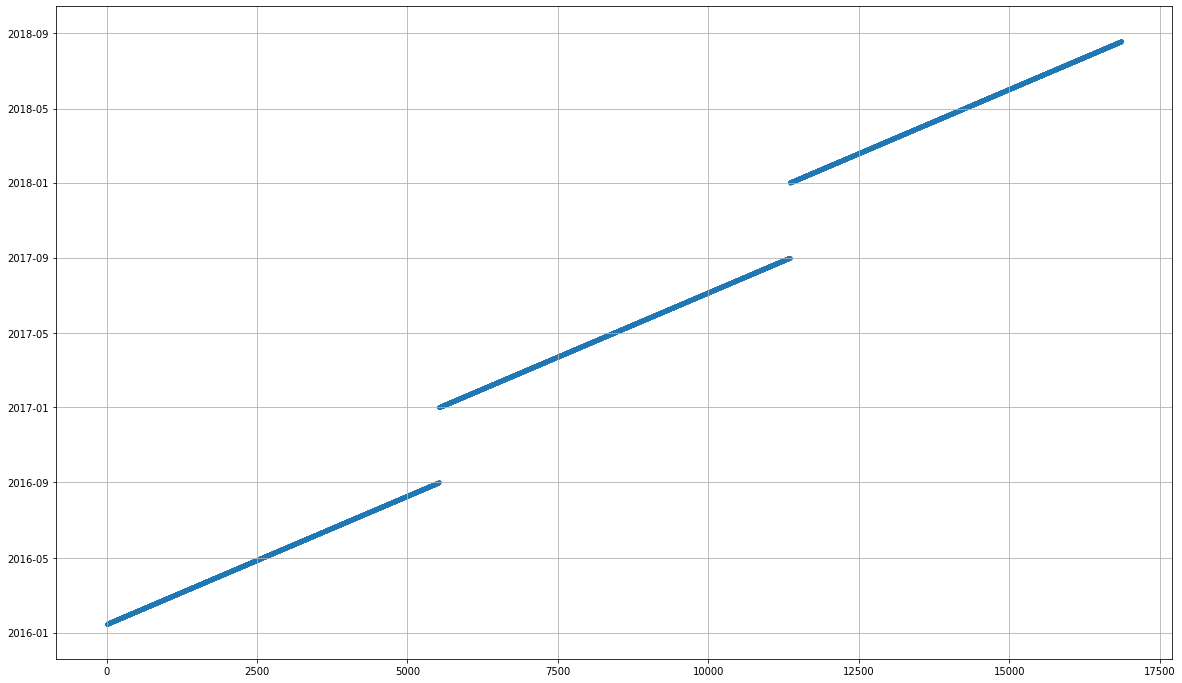

In [16]:
register_matplotlib_converters()

plt.figure(figsize=(20,12))
plt.scatter(train_df.index, train_df.date, marker='.')
plt.grid(True)

По графику видно, что **замеры разбиты на три отрезка**: 2016, 2017 и 2018 года.\
Каждый отрезок начинается в начале года и длится приблизительно **9** месяцев, содержит порядка **5500** измерений.

Посмотрим как меняются целевые признаки на протяжении всех измерений:

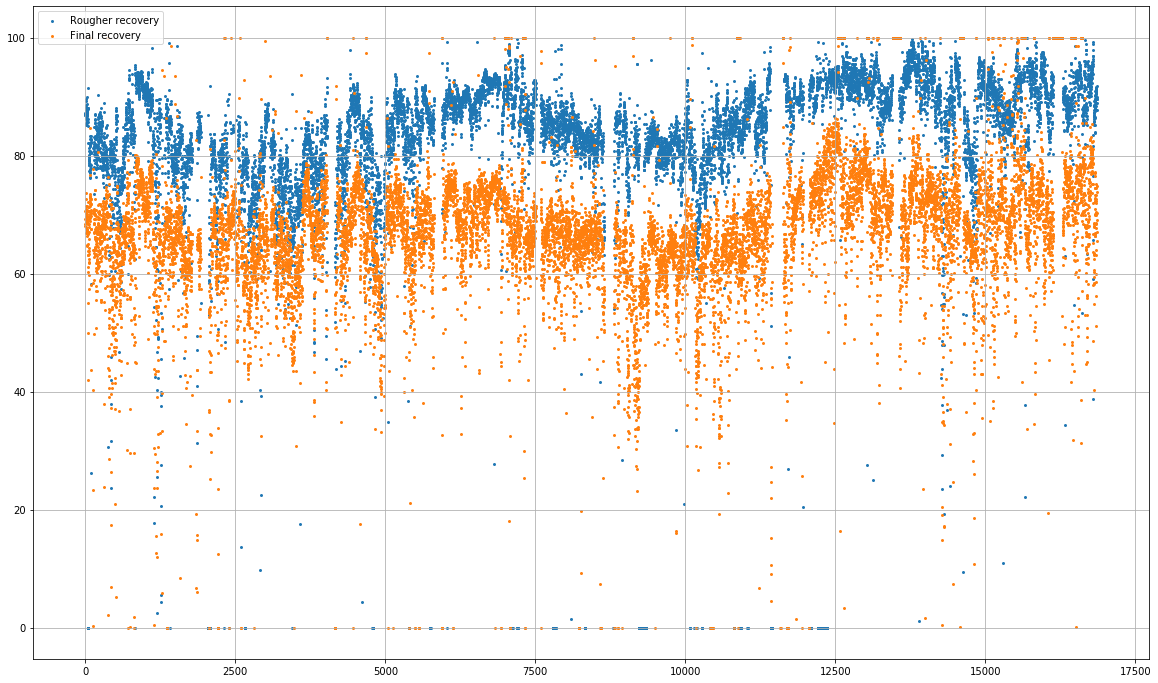

In [17]:
plt.figure(figsize=(20,12))
plt.scatter(train_df.index, train_df['rougher.output.recovery'], marker='.', linewidths=0, label='Rougher recovery')
plt.scatter(train_df.index, train_df['final.output.recovery'], marker='.', linewidths=0, label='Final recovery')
plt.grid(True)
plt.legend(loc='upper left')

**Из графика следует, что:**
- Соседние по времени значения находятся, как правило, на небольшом друг от друга расстоянии.
- Целевые признаки коррелируют между собой 
- Присутствует некоторое количество аномальных значений (близких к 0%/к 100%), но все лежат в разумных пределах.
- Пропуски в признаках встречаются, как правило, одновременно.
- В середине каждого из периодов значения в среднем ниже, чем в начале и конце.
- Есть тенденция повышения показателей из года в год.

Перед предобработкой тренировочного набора данных удалим от туда столбцы, которых нет в тестовом наборе (за исключением целевых признаков), чтобы модели не обучались по недоступным данным.

In [18]:
# сохраняем целевые столбцы
test_df_missing_columns.remove('final.output.recovery')
test_df_missing_columns.remove('rougher.output.recovery')

train_df = train_df.drop(test_df_missing_columns, axis=1)
len(train_df.columns)

55

Теперь, как и в тестовом наборе данных, тренировочная выборка имеет 53 столбца + 2 целевых.\
Узнаем количество пропусков в столбцах:

In [19]:
nan_in_train = []
for column in train_df.columns:
    nan_in_train.append(train_df[column].isna().sum())
    
nan_in_train = pd.Series(data=nan_in_train, index=train_df.columns)
nan_in_train.sort_values(ascending=False)

rougher.output.recovery                       2573
rougher.input.floatbank11_xanthate            1904
final.output.recovery                         1521
primary_cleaner.input.sulfate                 1307
primary_cleaner.input.depressant              1262
rougher.input.floatbank10_sulfate             1044
primary_cleaner.input.xanthate                 985
rougher.input.floatbank11_sulfate              623
rougher.state.floatbank10_e_air                603
rougher.input.feed_rate                        513
rougher.input.feed_size                        417
secondary_cleaner.state.floatbank2_a_air       363
rougher.input.floatbank10_xanthate             346
rougher.input.feed_sol                         292
rougher.input.feed_pb                          228
secondary_cleaner.state.floatbank2_b_air       155
secondary_cleaner.state.floatbank4_a_air       129
secondary_cleaner.state.floatbank3_a_level     113
secondary_cleaner.state.floatbank4_a_level     113
secondary_cleaner.state.floatba

В подавляющем большинстве столбцов присутствуют пропуски. Посмотрим, сколько останется данных, если мы удалим все строки с хотя бы одним пропущенным значением:

In [20]:
print('Before deleting:', len(train_df))
print('After deleting:', len(train_df.dropna()))

Before deleting: 16860
After deleting: 12679


Порядка **25%** строк содержат пропуски, в случае их удаления останется достаточно данных для обучения.\
Заполнение пропущенных значений средними может негативно сказаться на предсказаниях модели, поскольку может исказить информацию о процессе и результатах обогащения.\
Удалим все пропуски, а затем отделим целевые признаки. Их запишем в переменную **train_target**, а оставшиеся в **train_features**.

In [21]:
train_df = train_df.dropna()

target_names = ['final.output.recovery', 'rougher.output.recovery']

train_target = train_df[target_names]
# дата замера не влияет на процесс, поэтому ее стоит удалить
target_names.append('date')
train_features = train_df.drop(target_names, axis=1)

Еще раз взглянем на данные. Возможно, понадобится масштабирование для лучшего обучения моделей.

In [22]:
train_features.head(10)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,115.581252,12.470773,7.25,0.965760,1602.964922,-498.090944,1602.074298,-500.179481,1602.154812,-498.642614,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,117.322323,12.469088,7.25,0.895207,1597.532455,-500.985364,1602.816321,-500.696736,1603.572091,-500.256955,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,124.592960,12.467403,7.25,0.901202,1597.946266,-501.592304,1601.078254,-499.494115,1602.630688,-500.173741,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,131.781026,12.465718,7.25,0.885535,1601.670053,-499.548891,1598.804355,-499.689644,1601.689285,-500.484957,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,138.120409,12.464032,7.25,0.898779,1603.436598,-499.864400,1597.455353,-500.266905,1600.747882,-500.541002,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Значения сильно варьируются. Проведем масштабирование признаков:

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_features)
train_features[train_features.columns] = scaler.transform(train_features)
train_features.head(5)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.255098,0.297835,-0.14826,0.280500,-0.437702,-0.311161,-0.427903,-0.807763,-0.429701,-0.285943,...,-1.017430,-0.468697,-0.612782,-0.754839,-1.171437,-0.375955,-0.849788,-0.413723,-0.980522,-2.588727
1,-0.294389,0.348729,-0.14826,0.318901,-0.232889,-0.366283,-0.242114,-0.331740,-0.235842,-0.304190,...,-1.021762,-0.528342,-0.641186,-0.697371,-1.151871,-0.423793,-0.866353,-0.416488,-1.007619,-2.429464
2,-0.342991,0.657815,-0.14826,0.287423,-0.035848,-0.341190,-0.056933,-0.353094,-0.042805,-0.347942,...,-1.017751,-0.469348,-0.648362,-0.694006,-1.146418,-0.422742,-0.861271,-0.414881,-1.002250,-2.472607
3,-0.384614,0.659590,-0.14826,0.302539,-0.048168,-0.367578,-0.054868,-0.326306,-0.055418,-0.343944,...,-1.013959,-0.436440,-0.631866,-0.695030,-1.163733,-0.398885,-0.867651,-0.408375,-1.006344,-2.434960
4,-0.499631,0.838817,-0.14826,0.338804,-0.037528,-0.312912,-0.048967,-0.344905,-0.060778,-0.348451,...,-1.015585,-0.416289,-0.640703,-0.692656,-1.171424,-0.462808,-0.882152,-0.410865,-1.007921,-2.474430


## Вывод

Сделали то-то то-то на этом редобработку можно заканчивать.

---

# 2. Анализ данных

## Изменение концентрации металлов на различных этапах очистки.

По исходным данным посмотрим, как меняется концентрация **золота (Au), серебра (Ag) и свинца (Pb)** в зависимости от этапа очистки.

Искомые концентрации записаны в столбцах, оканчивающихся на **.concentrate_(Me)**.\
Запишем названия этих столбцов для трёх металлов в три соответсвующие им переменные:

In [24]:
# для удобства запишем переменные в список (список списков)
Au_concentrate_cols=[]
Ag_concentrate_cols=[]
Pb_concentrate_cols=[]
me_lists = [Au_concentrate_cols, Ag_concentrate_cols, Pb_concentrate_cols]

# строки для поиска
me_strings = ['.concentrate_au', '.concentrate_ag', '.concentrate_pb']

def find_columns_by_string(df, string):
    output_list = []
    for column in df.columns:
        if string in column:
            output_list.append(column)
    return output_list

for i in range(3):
    me_lists[i] = find_columns_by_string(full_df, me_strings[i])

#### Проверим запись

In [25]:
for i in range(3):
    display(full_df[me_lists[i]].head(3))

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.output.concentrate_au
0,42.192020,34.174427,19.793808
1,42.701629,34.118526,20.050975
2,42.657501,33.969464,19.737170


,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.output.concentrate_ag
0,6.055403,8.547551,11.500771
1,6.029369,8.558743,11.615865
2,6.055926,8.603505,11.695753


,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.output.concentrate_pb
0,9.889648,10.389648,7.101074
1,9.968944,10.497069,7.278807
2,10.213995,10.354494,7.216833


Столбцы идут в обратном порядке.\
Исправим это, чтобы не было проблем с выводом графиков.

In [26]:
for i in range(3):
    me_lists[i].reverse()
    display(full_df[me_lists[i]].head(1))

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,19.793808,34.174427,42.19202


,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
0,11.500771,8.547551,6.055403


,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,7.101074,10.389648,9.889648


### Cтроим искомое распределение:

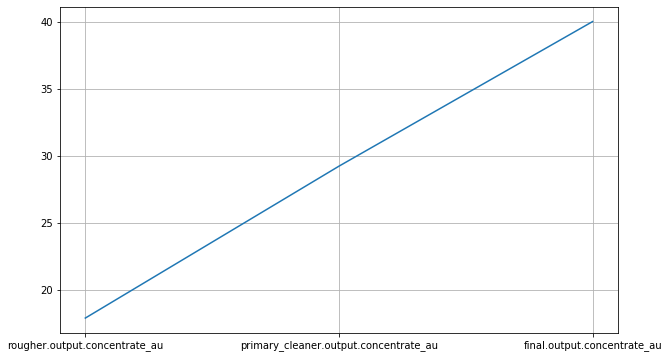

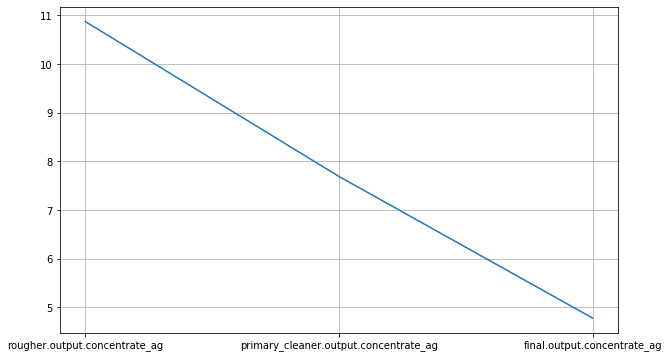

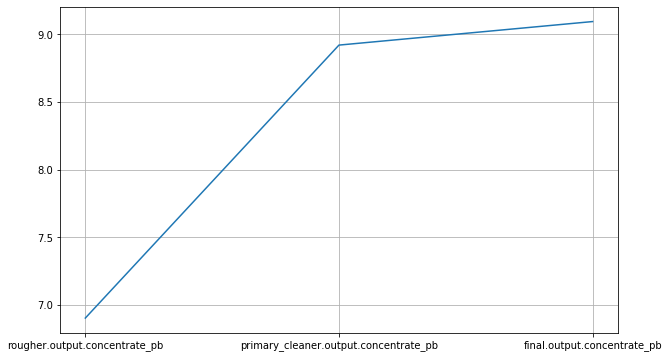

In [27]:
for i in range(3):
    plt.figure(figsize=(10,6))
    plt.plot(full_df[me_lists[i]].mean())
    plt.grid(True)
    plt.show()   

#### Вывод:
- **Концентрация золота (Au)** равномерно **растет** от этапа к этапу.
- **Концентрация серебра (Ag)** равномерно **падает** на каждом этапе.
- **Концентрация свинца (Pb)** **растет**, причем наибольший рост концентрации просиходит после первого этапа очистки, и совсем немного - на втором этапе.

---

## Распределение размеров гранул сырья на обучающей и тестовой выборках

Посмотрим, как распределяется размер гранул сырья на двух выборках, чтобы избежать ошибок в обучении моделей.\
Интересующие нас столбцы:
- **rougher.input.feed_size**
- **primary_cleaner.input.feed_size**

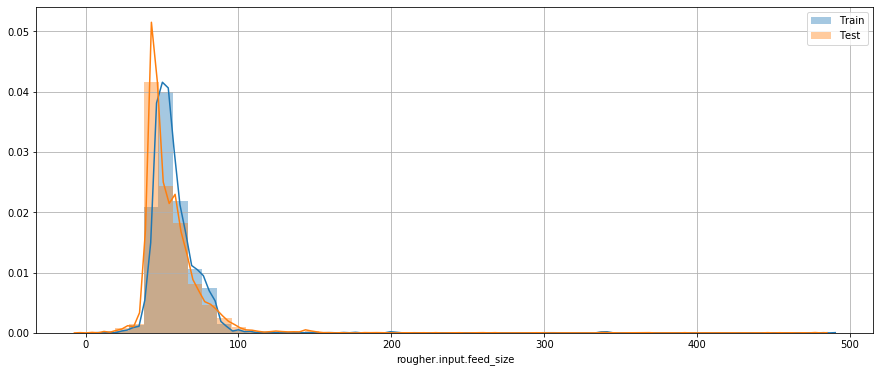

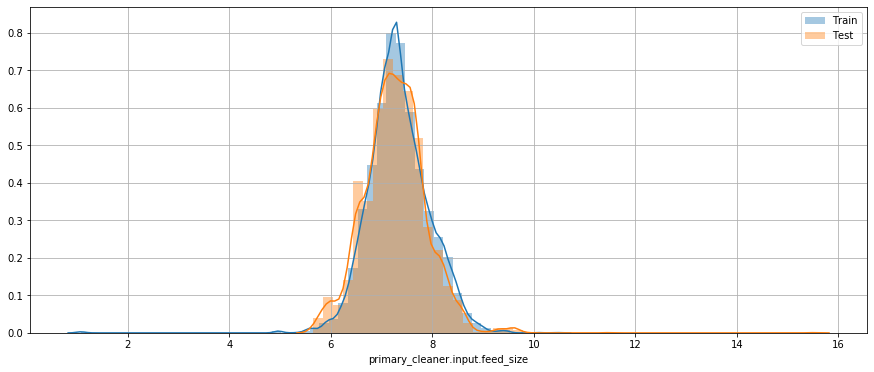

In [28]:
feed_size_columns = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']
for column in feed_size_columns:
    plt.figure(figsize=(15,6))
    for df in [train_df, test_df]:
        sns.distplot(df[column].dropna())
    plt.legend(['Train', 'Test'])
    plt.grid(True)    
    plt.show()

#### Распределения немного отличаются на первом этапе, и схожи во втором. На качество обучения разница не должна повлиять.

---

## Суммарная концентрация веществ на разных этапах

Изучим, как меняется суммарная концентрация веществ в зависимости от этапа.

Ранее, названия столбцов с концентрациями каждого металла были записаны в список **me_lists**.\
Воспользуемся им для нахождения суммарной концентрации по этапам, однако в этом списке отсутствуют названия столбцов с концентрацией сырья. Добавим эти столбцы:

In [29]:
# ранее созданная функция find_columns_by_string не подойдет,
# т.к. нельзя выделить нужные столбцы, не добавив лишние

# записываем искомые столбцы вручную
me_feed_names = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']

# добавляем в списки "с металлами"
for i in range(3):
    me_lists[i].append(me_feed_names[i])

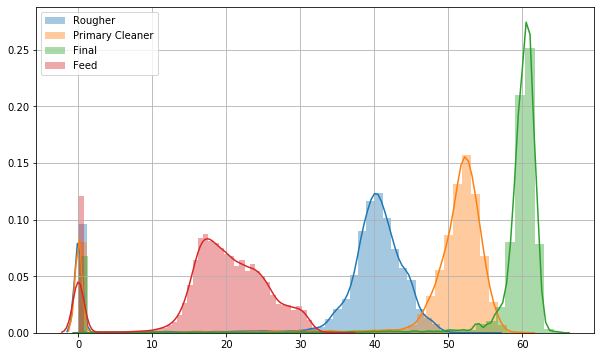

In [30]:
plt.figure(figsize=(10,6))

# Для каждого этапа заполняем список, в котором записываем сумму концентраций во всех металлах (построчно)
for stage in range(4):
    stages_sum = []
    for i in range(len(full_df)):
        summary = 0
        for me in range(3):
            summary += full_df[me_lists[me][stage]][i]
        stages_sum.append(summary)
        
    stages_sum = pd.Series(stages_sum)
    sns.distplot(stages_sum.dropna())
plt.legend(['Rougher', 'Primary Cleaner', 'Final', 'Feed'])
plt.grid(True)
plt.show()

По графикам видно, что суммарная концентрация веществ растет с каждым последующим этапом.\
Также на каждом из этапов присутствует значительное количество нулевых значений. Они могут негативно сказаться на обучении моделей.\
Стоит удалить такие значения из тренировочной и тестовой выборок (переменные **train_features** и **test_df**).

Поскольку в этих выборках есть только данные о сырье, удаляем нулевые значения именно для него.

#### train_features:

Поскольку ранее была проведена предобработка обучающей выборки, аномальные значения могли быть удалены в ходе предобработки. Посмотрим, присутствуют ли аномальные значения:

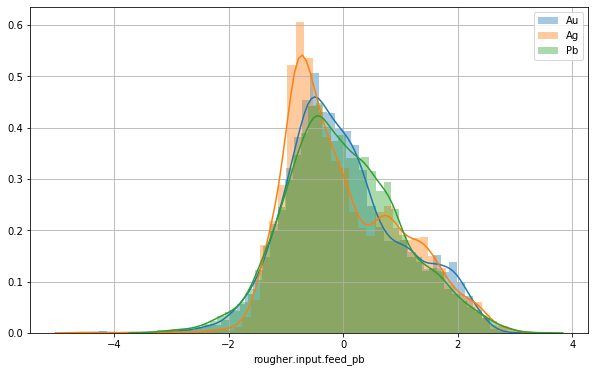

In [31]:
plt.figure(figsize=(10,6))
for feed_name in me_feed_names:
    sns.distplot(train_features[feed_name])
    plt.legend(['Au', 'Ag', 'Pb'])

plt.grid(True)
plt.show()

Распределение выглядит также как и на общем графике для всех этапов, причем аномальных значений нет.\
Выходит, они были удалены ранее.\
Вероятно, выбросы были на тех же строках, в которых были пропуски/иные проблемы, поэтому они были удалены в ходе предобработки.

#### test_df

Теперь взглянем на тестовую выборку:

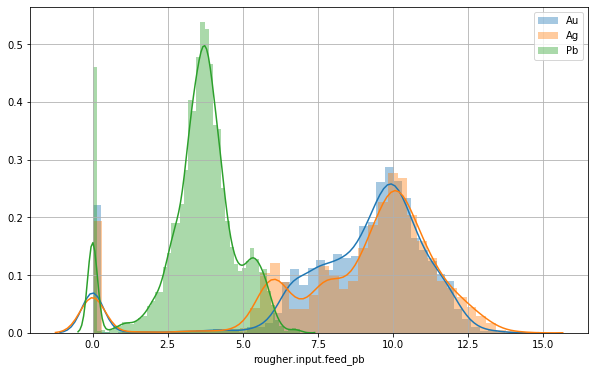

In [32]:
plt.figure(figsize=(10,6))
for feed_name in me_feed_names:
    sns.distplot(test_df[feed_name].dropna())
    plt.legend(['Au', 'Ag', 'Pb'])

plt.grid(True)
plt.show()

Присутствуют аномальные значения и пропуски - удалим их:

In [33]:
test_df = test_df.dropna()

for feed_name in me_feed_names:
    test_df = test_df[test_df[feed_name] != 0]

Распределение концентраций веществ в сырье после обработки:

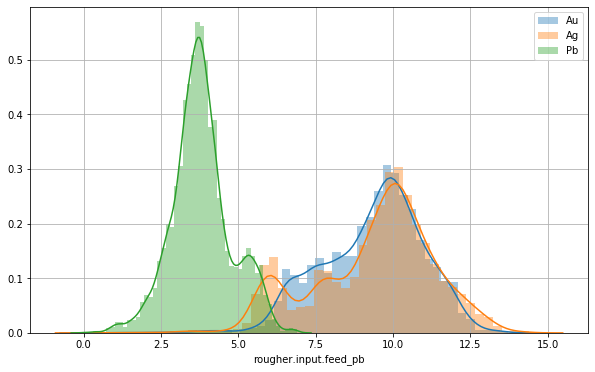

In [34]:
plt.figure(figsize=(10,6))
for feed_name in me_feed_names:
    sns.distplot(test_df[feed_name].dropna())
    plt.legend(['Au', 'Ag', 'Pb'])

plt.grid(True)
plt.show()

Аномальные значения и выбросы удалены.

### Анализ закончен, можно приступать к построению моделей.

---

# 3. Модель

## Функция для вычисления итогового *sMAPE*

В данной задаче целевой метрикой является ***sMAPE*** (Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

### Метрика вычисляется по следующей формуле:
$$sMAPE = \frac{1}{N}
\displaystyle\sum_{i=1}^{N}
\frac{|y_i - y_i^{пр}|}{(|y_i| + |y_i^{пр}|)/2}*100\%$$

#### Где:
- $y_i$ - истинное значение целевого признака с порядковым номером $i$
- $y_i^{пр}$ - предсказанное значение целевого признака с порядковым номером $i$
- $N$ - количество объектов в выборке

### Нужно спрогнозировать две величины:
- эффективность обогащения чернового концентрата **rougher.output.recovery**
- эффективность обогащения финального концентрата **final.output.recovery**

### Итоговая метрика вычисляется следующим образом:
$$Итоговое\ sMAPE = 25\%*sMAPE(rougher) + 75\%*sMAPE(final)$$
---
Функция должна брать на вход **4** списка: Предсказания для **rougher** и **final** и соответствующие им верные ответы.\
Результатом работы функции будет значение **итогового** ***sMAPE***

In [35]:
def smape(predict, target):
    target = target.tolist()
    predict = predict.tolist()
    total = 0
    for i in range(len(predict)):
        # добавляем try except, чтобы не допустить деления на ноль
        try:
            total += abs(target[i] - predict[i])*2 / (abs(target[i]) + abs(predict[i])) * 100
        except:
            total += 0
    return total/len(predict)

In [36]:
def final_smape(r_predict, f_predict, r_target, f_target):
    return 0.25*smape(r_predict, r_target) + 0.75*smape(f_predict, f_target)

Функция готова, можно переходить к обучению моделей.

---

## Обучение и проверка моделей

Перед нами стоит задача регрессии, поэтому подойдут модели **LinearRegression** и **RandomForestRegressor**.
Для их настройки воспользуемся методом **RandomizedSearchCV** библиотеки scikit-learn (подбор параметров через **GridSearchCV** займет слишком много времени).

При этом для оценки моделей воспользуемся ранее созданной функцией ***smape***

## Случайный лес

Импортируем библиотеки

In [37]:
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

Функция для оценки качества модели

In [38]:
smape_score = make_scorer(smape, greater_is_better=False)

#### Модель для предсказания признака **rougher.output.recovery**

In [39]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()

forest_random = RandomizedSearchCV(estimator = model, scoring=smape_score, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
forest_random.fit(train_features, train_target['rougher.output.recovery'])
forest_random.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.4min finished


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

Сохраняем лучшую найденную модель и оцениваем ее качество с помощью кросс-валидации

In [40]:
forest_best_rougher = forest_random.best_estimator_

cross_val_score(forest_best_rougher, train_features, train_target['rougher.output.recovery'], cv=3, scoring=smape_score)

array([ -8.8233471 , -10.61973244, -12.99332819])

#### Модель для предсказания признака **final.output.recovery**

In [41]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]

max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestRegressor()

forest_random = RandomizedSearchCV(estimator = model, scoring=smape_score, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
forest_random.fit(train_features, train_target['final.output.recovery'])
forest_random.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.3min finished


{'n_estimators': 40,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

Сохраняем лучшую найденную модель и оцениваем ее качество с помощью кросс-валидации

In [42]:
forest_best_final = forest_random.best_estimator_

cross_val_score(forest_best_final, train_features, train_target['final.output.recovery'], cv=3, scoring=smape_score)

array([-11.31338482,  -9.83100693, -12.27642486])

Получаем неплохие показатели качества: ошибка составляет приблизительно 10% для обоих целевых признаков (чем ниже метрика sMAPE, тем лучше результат).

## Линейная регрессия

Импортируем библиотеки

In [43]:
from sklearn.linear_model import LinearRegression

#### Модель для предсказания признака **rougher.output.recovery**

Для линейной регрессии не требуется настраивать гиперпараметры, как в случае со случайным лесом,\
поэтому просто импортируем модель и проверяем ее качество с помощью кросс-валидации

In [44]:
linear_model_rougher = LinearRegression()
linear_model_rougher.fit(train_features, train_target['rougher.output.recovery'])

cross_val_score(linear_model_rougher, train_features, train_target['rougher.output.recovery'], cv=3, scoring=smape_score)

array([-12.16836645, -11.17103095, -12.03301409])

#### Модель для предсказания признака **final.output.recovery**

In [45]:
linear_model_final = LinearRegression(normalize=True)
linear_model_final.fit(train_features, train_target['final.output.recovery'])

cross_val_score(linear_model_final, train_features, train_target['final.output.recovery'], cv=3, scoring=smape_score)

array([-10.61951238, -10.03363609, -15.81560604])

Качество линейной регресси несколько ниже, по сравнению с моделью случайного леса, однако скорость обучения выше.

---

## Выбор лучшей модели

#### Оценим качество моделей для итоговой метрики на тесте, чтобы выбрать лучшую.

Для оценки качества, загрузим целевой признак для тестовой выборки из полного датасета в отдельную переменную.

In [46]:
test_target = pd.DataFrame()
test_target['rougher.output.recovery'] = full_df['rougher.output.recovery'][test_df.index]
test_target['final.output.recovery'] = full_df['final.output.recovery'][test_df.index]
len(test_target)

5357

Убедимся в отсутствии пропусков:

In [47]:
print(test_target['rougher.output.recovery'].isna().sum())
print(test_target['final.output.recovery'].isna().sum())

775
563


От пропусков необходимо избавиться, чтобы не возникло ошибок при подсчете итоговой метрики.

In [48]:
test_target = test_target.dropna()
test_df = test_df.loc[test_target.index]
len(test_df)

4529

---

#### Итоговая оценка для модели Случайного леса:

In [49]:
r_predictions = forest_best_rougher.predict(test_df.drop(['date'], axis=1))
f_predictions = forest_best_final.predict(test_df.drop(['date'], axis=1))

final_smape(r_predictions, f_predictions, test_target['rougher.output.recovery'], test_target['final.output.recovery'])

11.396827618938255

#### Итоговая оценка для модели Линейной регрессии:

In [50]:
# для корректных результатов, масштабируем выборку перед предсказаниями
r_predictions = linear_model_rougher.predict(scaler.transform(test_df.drop(['date'], axis=1)))
f_predictions = linear_model_final.predict(scaler.transform(test_df.drop(['date'], axis=1)))

final_smape(r_predictions, f_predictions, test_target['rougher.output.recovery'], test_target['final.output.recovery'])

13.222228563438877

#### Наилучшие результаты показала модель Случайного леса.

### Итоговое sMAPE на тестовой выборке: 11.4

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке